In [ ]:
import zipfile as zf
files = zf.ZipFile("faces.zip",'r')
files.extractall()
files.close()

In [ ]:
import torch
import torch.nn as nn
from math import prod,sqrt
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
from pathlib import Path
import torch.nn.functional as F
import gc
import random
import pandas as pd
to_tensor = ToTensor()
to_pil = ToPILImage()


In [ ]:
path = Path("faces/")

In [ ]:
files = path.ls(); files

(#16738) [Path('faces/0_adios_gato_0_01644.jpg'),Path('faces/0_adios_gato_0_03778.jpg'),Path('faces/0_adios_gato_0_15888.jpg'),Path('faces/0_adios_gato_0_21347.jpg'),Path('faces/0_adios_gato_0_23496.jpg'),Path('faces/0_adios_gato_0_24303.jpg'),Path('faces/0_adios_gato_0_31689.jpg'),Path('faces/0_adios_gato_0_55729.jpg'),Path('faces/0_adios_gato_0_62758.jpg'),Path('faces/0_adios_gato_1_08248.jpg')...]

In [ ]:
files = fv.get_image_files("faces/")
files[0]

Path('faces/0_adios_gato_0_01644.jpg')

In [ ]:
def get_image(x):
    return float(x.name.split("_")[0])

39_hola_mama_1_09030.jpg --> 39.0


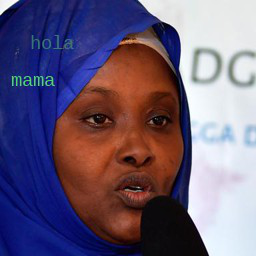

In [ ]:
f = random.choice(files)
print(f"{f.name} --> {get_image(f)}")
fv.PILImage.create(f)

In [ ]:
def get_catA(x):
    return (x.name.split("_")[1])

38_adios_mama_0_35974.jpg --> adios


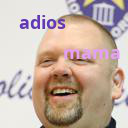

In [ ]:
f = random.choice(files)
print(f"{f.name} --> {get_catA(f)}")
fv.PILImage.create(f)

In [ ]:
def get_catB(x):
    return (x.name.split("_")[2])

3_adios_papa_1_37777.jpg --> papa


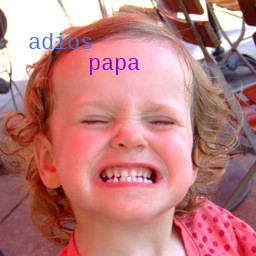

In [ ]:
f = random.choice(files)
print(f"{f.name} --> {get_catB(f)}")
fv.PILImage.create(f)

In [ ]:
def load_data(folder, img_size, batch_size):
    
    tfms = fv.aug_transforms(size = img_size,flip_vert=False,do_flip=False, max_rotate=10, max_lighting=0.25,max_zoom=1.1,max_warp=0.1)
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock,fv.RegressionBlock,fv.CategoryBlock,fv.CategoryBlock),
                        n_inp     = 1,
                        get_items = fv.get_image_files,
                        get_y     = [get_image, get_catA,get_catB],
                        splitter  = fv.RandomSplitter(0.08),
                        item_tfms = fv.Resize(int(1*img_size)),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [ ]:
data = load_data(path, img_size=128, batch_size=128)

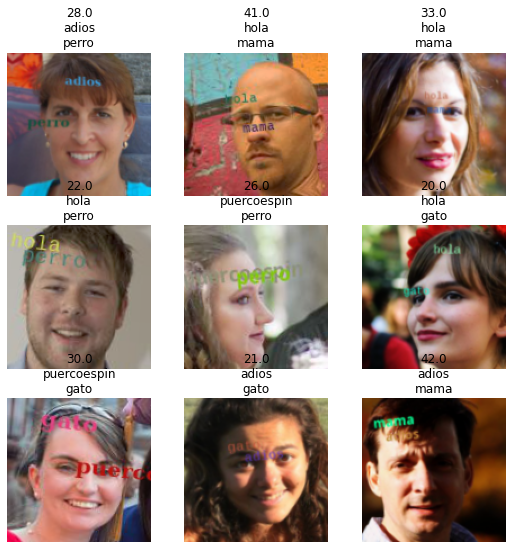

In [ ]:
data.show_batch()

In [ ]:
b = data.one_batch()

In [ ]:
b

(TensorImage([[[[6.0453e-01, 5.8561e-01, 5.5774e-01,  ..., 5.1654e-01,
            5.2236e-01, 5.2667e-01],
           [6.7734e-01, 6.4377e-01, 6.0433e-01,  ..., 5.0438e-01,
            5.1003e-01, 5.1437e-01],
           [7.3894e-01, 7.0579e-01, 6.6632e-01,  ..., 4.9057e-01,
            4.9621e-01, 4.9884e-01],
           ...,
           [6.6938e-01, 6.6902e-01, 6.6830e-01,  ..., 8.8790e-01,
            8.9059e-01, 8.9150e-01],
           [6.7318e-01, 6.7318e-01, 6.7316e-01,  ..., 8.7751e-01,
            8.7476e-01, 8.7985e-01],
           [6.7318e-01, 6.7318e-01, 6.7318e-01,  ..., 8.4836e-01,
            8.4507e-01, 8.5011e-01]],
 
          [[6.3448e-01, 6.1648e-01, 5.8966e-01,  ..., 5.6337e-01,
            5.7037e-01, 5.7474e-01],
           [7.1439e-01, 6.8082e-01, 6.4155e-01,  ..., 5.4820e-01,
            5.5785e-01, 5.6226e-01],
           [7.8934e-01, 7.5653e-01, 7.1646e-01,  ..., 5.3098e-01,
            5.4162e-01, 5.4378e-01],
           ...,
           [7.1536e-01, 7.1499e-0

In [ ]:
b[0].shape

torch.Size([128, 3, 128, 128])

In [ ]:
b[1].shape

torch.Size([128])

In [ ]:
b[2].shape

torch.Size([128])

In [ ]:
b[3].shape

torch.Size([128])

In [ ]:
class Normalizer(nn.Module):
    def __init__(self, mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
        
    def forward(self,x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [ ]:
class FullFlatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.reshape(-1)

Without rescaling

In [ ]:
def MFE(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return F.mse_loss(pred_age,age) + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
def resnet_split(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [ ]:
def age_l1(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    return F.l1_loss(pred_age,age)

In [ ]:
def CatA_accuracy(yp, age, Cat1, Cat2):
    pred_CatA = yp[:,1:4]
    return fv.accuracy(pred_CatA,Cat1)

In [ ]:
def CatB_accuracy(yp, age, Cat1, Cat2):
    pred_CatB = yp[:,4:]
    return fv.accuracy(pred_CatB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model = nn.Sequential(*layers)

In [ ]:
learn = fv.Learner(data, model, opt_func = fv.ranger, loss_func = MFE, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=7.585775847473997e-07)

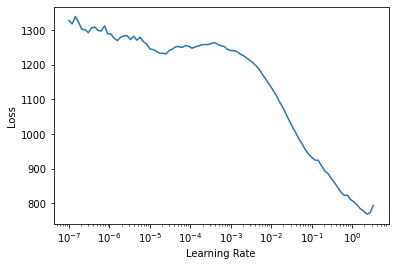

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,125.425201,97.325546,7.212517,0.303211,0.238984,00:14
1,89.688614,54.598919,5.347066,0.335325,0.235997,00:13
2,64.223610,57.365372,5.424419,0.341299,0.248693,00:13
3,44.023582,39.817272,4.533181,0.362211,0.258402,00:14
4,31.665468,39.548157,4.483827,0.365198,0.259895,00:13


Trying opt_func Adam 

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model2 = nn.Sequential(*layers)

In [ ]:
learn2 = fv.Learner(data, model2, loss_func = MFE, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.007585775572806597)

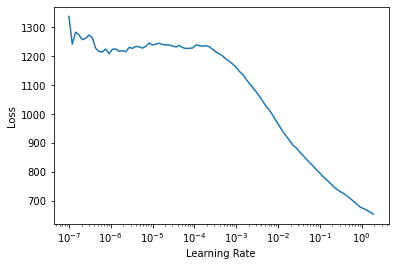

In [ ]:
learn2.lr_find()

In [ ]:
learn2.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,191.715469,373.292450,15.380683,0.345780,0.268111,00:14
1,112.879913,113.848068,7.577545,0.345034,0.236744,00:13
2,80.355469,97.748489,7.388406,0.339806,0.260642,00:13
3,57.047451,54.168297,5.369774,0.324122,0.268111,00:13
4,43.202591,43.757671,4.686268,0.320388,0.261389,00:13


Ranger was  better

In [ ]:
def MFED10(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return F.mse_loss(pred_age,age)/10 + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model3 = nn.Sequential(*layers)

In [ ]:
learn3 = fv.Learner(data, model3, opt_func = fv.ranger, loss_func = MFED10, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.9054607491852948e-06)

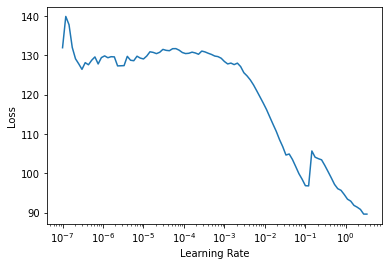

In [ ]:
learn3.lr_find()

In [ ]:
learn3.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,31.419060,17.300953,9.333812,0.353249,0.241225,00:13
1,13.582932,9.926674,6.525528,0.338312,0.250934,00:13
2,8.875396,10.034301,6.477263,0.345780,0.243465,00:13
3,6.661966,6.849847,4.832802,0.358476,0.247946,00:13
4,5.541658,5.877682,4.237330,0.369679,0.245706,00:13


In [ ]:
def MFED30(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return F.mse_loss(pred_age,age)/30 + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model4 = nn.Sequential(*layers)

In [ ]:
learn4 = fv.Learner(data, model4, opt_func = fv.ranger, loss_func = MFED30, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.02290867641568184)

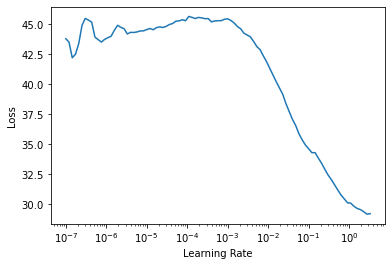

In [ ]:
learn4.lr_find()

In [ ]:
learn4.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,13.063017,9.745635,12.116405,0.401046,0.247946,00:13
1,5.806276,4.362471,5.827511,0.531740,0.250934,00:13
2,4.397989,3.733263,4.828142,0.587752,0.283047,00:13
3,3.520586,3.327901,4.393331,0.634055,0.289768,00:13
4,2.983274,3.256303,4.361885,0.672890,0.280807,00:13


In [ ]:
def MFEDSQRT(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return torch.sqrt(F.mse_loss(pred_age,age)) + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model5 = nn.Sequential(*layers)

In [ ]:
learn5 = fv.Learner(data, model5, opt_func = fv.ranger, loss_func = MFEDSQRT, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.02754228748381138)

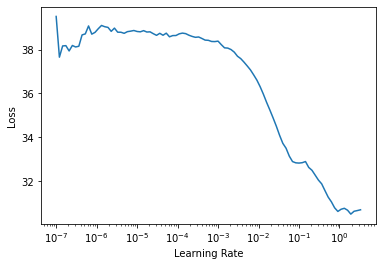

In [ ]:
learn5.lr_find()

In [ ]:
learn5.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,18.351316,13.441814,7.995930,0.445855,0.272591,00:13
1,12.624413,10.804446,5.987846,0.459298,0.253174,00:13
2,10.609743,11.450398,6.791436,0.523525,0.263630,00:13
3,8.916058,9.043516,5.094949,0.590739,0.263630,00:13
4,7.820549,8.138604,4.365154,0.611650,0.269604,00:13


In [ ]:
def MFEDSQRT10(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return torch.sqrt(F.mse_loss(pred_age,age))/10 + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model6 = nn.Sequential(*layers)

In [ ]:
learn6 = fv.Learner(data, model6, opt_func = fv.ranger, loss_func = MFEDSQRT10, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.033113110810518265)

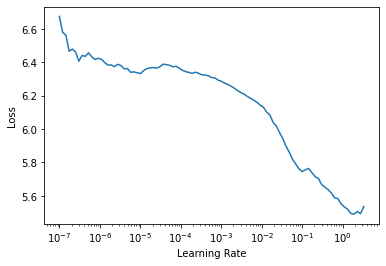

In [ ]:
learn6.lr_find()

In [ ]:
learn6.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,3.964557,3.765794,9.668612,0.586258,0.286034,00:13
1,2.811264,2.335848,7.009325,0.810306,0.557132,00:13
2,2.047061,1.657032,6.282488,0.903659,0.757282,00:13
3,1.466471,1.310120,5.131601,0.928305,0.828977,00:13
4,1.148583,1.243171,4.982540,0.932786,0.838686,00:13


In [ ]:
learn6.validate()

(#4) [1.2431708574295044,4.982539653778076,0.93278568983078,0.8386855721473694]

In [ ]:
def resnet_split(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [ ]:
def MFEDSQRT10(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return torch.sqrt(F.mse_loss(pred_age,age))/10 + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
model7 = nn.Sequential(*layers)

In [ ]:
learn7 = fv.Learner(data, model7, opt_func = fv.ranger, splitter=resnet_split, loss_func = MFEDSQRT10, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.6309573650360107)

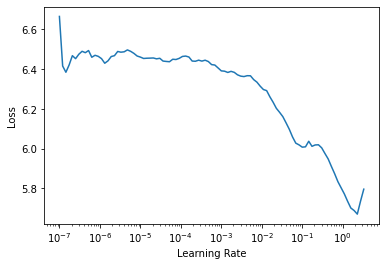

In [ ]:
learn7.lr_find()

In [ ]:
learn7.fit_one_cycle(25,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,5.288988,4.459579,21.800047,0.678118,0.373413,00:17
1,2.884271,2.096726,6.396752,0.822255,0.657954,00:17
2,2.222084,1.944029,6.516190,0.846901,0.695295,00:17
3,2.152533,1.973662,8.054108,0.878267,0.735624,00:17
4,2.101762,1.877211,6.461202,0.861090,0.758028,00:17
5,2.028488,1.719018,7.326379,0.893951,0.800597,00:17
6,1.872561,1.915667,9.411714,0.905153,0.808813,00:17
7,1.703651,1.400230,5.730031,0.913368,0.830471,00:17
8,1.615696,1.459203,6.410104,0.934279,0.843913,00:17
9,1.539178,1.395835,6.099360,0.938013,0.838686,00:16


In [ ]:
learn7.unfreeze()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=6.309573450380412e-07)

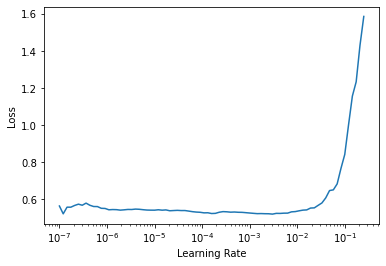

In [ ]:
learn7.lr_find()

In [ ]:
learn7.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,0.702635,1.070535,4.899830,0.955937,0.890217,00:17
1,0.952450,1.126516,5.054492,0.956684,0.887976,00:17
2,0.912985,1.081577,4.926885,0.954444,0.895444,00:16
3,0.705069,0.986309,4.748446,0.963406,0.904406,00:17
4,0.580187,0.987852,4.711941,0.967887,0.905153,00:17


In [ ]:
learn7.validate()

(#4) [0.9878523945808411,4.711941242218018,0.9678865075111389,0.9051530957221985]

In [ ]:
def show_results(self,max_n=16):
    dl = self.dls.valid.new(shuffle=True)
    x,y,catA,catB= dl.one_batch()
    yp = self.model(x)#.view(-1)
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    ctx = fv.get_grid(max_n)
    for i in range(max_n):
        fv.show_image(x[i],ctx=ctx[i],title=f"{yp[i,0]:.1f} | {int(y[i])} \n {yp[i,1]:.1f}/{yp[i,2]:.1f}/{yp[i,3]:.1f} | {catA[i]} \n {yp[i,4]:.1f}/{yp[i,5]:.1f}/{yp[i,6]:.1f}/{yp[i,7]:.1f} | {catB[i]}")# (Δ = {y[i] - yp[i]:.})")

In [ ]:
fv.Learner.show_results = show_results

The encoding for the first categorie are adios = 0 hola = 1 puercoespin = 2 <br/>
The encoding for the second categorie are  papa = 0 mama = 1 gato = 2 perro = 3

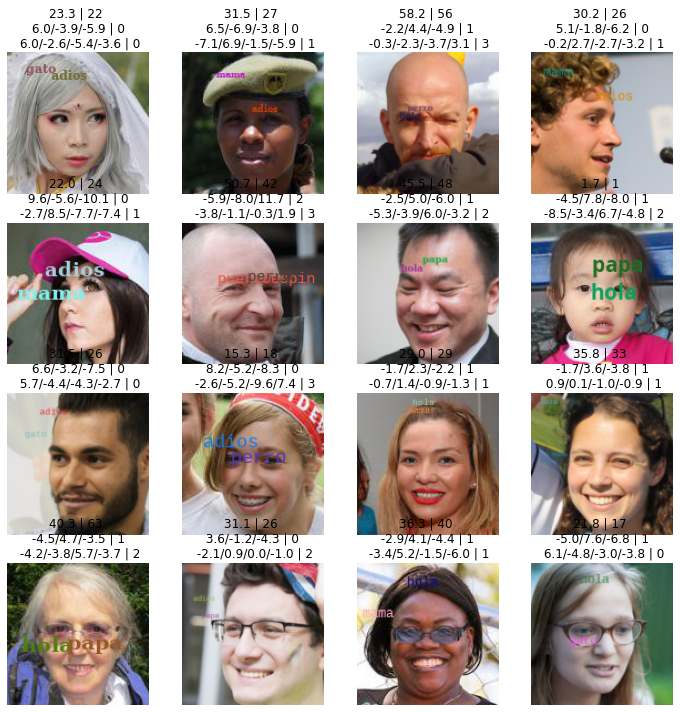

In [ ]:
learn7.show_results()

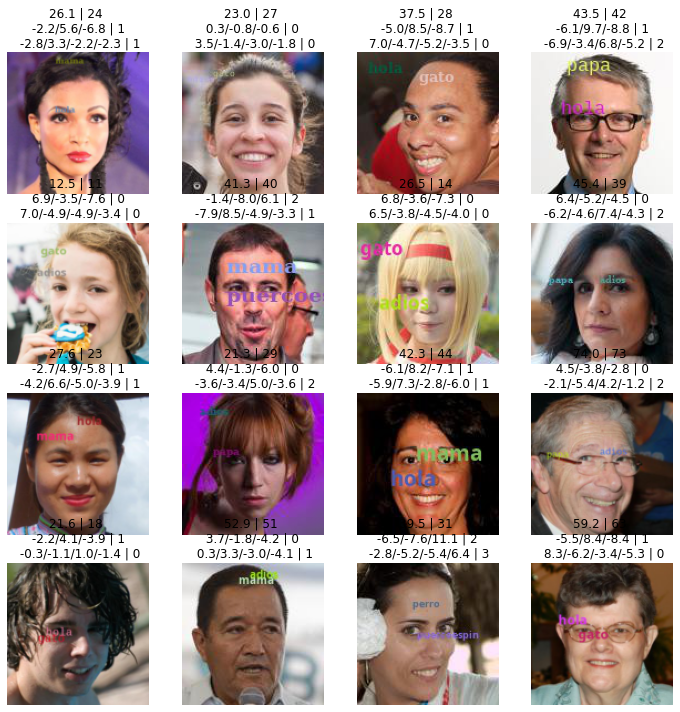

In [ ]:
learn7.show_results()

In [ ]:
learn7.validate()

(#4) [0.9878523945808411,4.711941242218018,0.9678865075111389,0.9051530957221985]

Trying to improve with resnet101

In [ ]:
def resnet_split(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [ ]:
def MFEDSQRT10(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return torch.sqrt(F.mse_loss(pred_age,age))/10 + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
def load_data(folder, img_size, batch_size):
    
    tfms = fv.aug_transforms(size = img_size,flip_vert=False,do_flip=False, max_rotate=10, max_lighting=0.25,max_zoom=1.1,max_warp=0.1)
    
    data = fv.DataBlock(
                        blocks    = (fv.ImageBlock,fv.RegressionBlock,fv.CategoryBlock,fv.CategoryBlock),
                        n_inp     = 1,
                        get_items = fv.get_image_files,
                        get_y     = [get_image, get_catA,get_catB],
                        splitter  = fv.RandomSplitter(0.08),
                        item_tfms = fv.Resize(int(1*img_size)),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(folder,bs=batch_size)

In [ ]:
data = load_data(path, img_size=128, batch_size=64)

In [ ]:
layers = [Normalizer()] + list(fv.resnet101(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(2048,8)]

In [ ]:
model8 = nn.Sequential(*layers)

In [ ]:
learn8 = fv.Learner(data, model8, opt_func = fv.ranger, loss_func = MFEDSQRT10, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

In [ ]:
learn8.model

Sequential(
  (0): Normalizer()
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (5): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.013182567432522774)

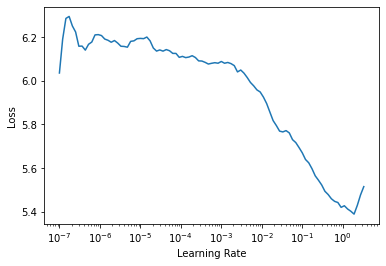

In [ ]:
learn8.lr_find()

In [ ]:
learn8.fit_one_cycle(15,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,2.889392,2.441497,7.364681,0.793876,0.579537,01:33
1,2.452809,2.141805,8.170847,0.860344,0.711725,01:33
2,2.446978,2.435488,8.870853,0.843913,0.665422,01:33
3,2.283181,1.902806,7.521969,0.900672,0.727409,01:33
4,2.025157,1.625415,6.882562,0.901419,0.789395,01:33
5,1.807452,1.558951,7.323541,0.920836,0.840179,01:33
6,1.681628,1.415186,6.640910,0.920836,0.856609,01:33
7,1.492304,1.295740,6.302454,0.941748,0.870052,01:34
8,1.353186,1.238101,6.036057,0.941001,0.886482,01:33
9,1.194724,1.287658,6.383271,0.944735,0.887229,01:33


In [ ]:
learn8.validate()

(#4) [0.9676735997200012,5.221680164337158,0.9701269865036011,0.9223300814628601]

In [ ]:
def show_results(self,max_n=16):
    dl = self.dls.valid.new(shuffle=True)
    x,y,catA,catB= dl.one_batch()
    yp = self.model(x)#.view(-1)
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    ctx = fv.get_grid(max_n)
    for i in range(max_n):
        fv.show_image(x[i],ctx=ctx[i],title=f"{yp[i,0]:.1f} | {int(y[i])} \n {yp[i,1]:.1f}/{yp[i,2]:.1f}/{yp[i,3]:.1f} | {catA[i]} \n {yp[i,4]:.1f}/{yp[i,5]:.1f}/{yp[i,6]:.1f}/{yp[i,7]:.1f} | {catB[i]}")# (Δ = {y[i] - yp[i]:.})")

In [ ]:
fv.Learner.show_results = show_results

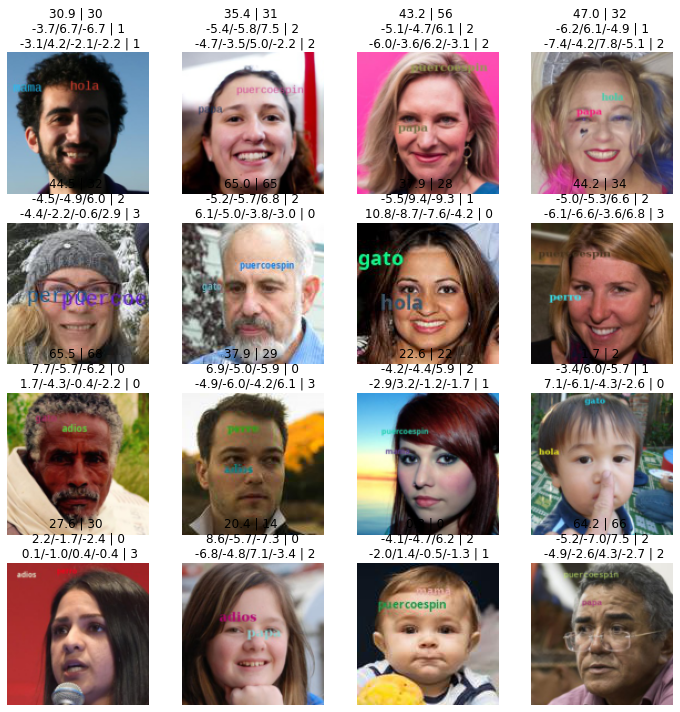

In [ ]:
learn8.show_results()

Was better my learn7 and resnet18


In [ ]:
def MFE(yp, age, Cat1, Cat2):
    pred_age = yp[:,0]
    pred_catA = yp[:,1:4]
    pred_catB = yp[:,4:]
    
    return F.mse_loss(pred_age,age) + F.cross_entropy(pred_catA,Cat1) + F.cross_entropy(pred_catB,Cat2)

In [ ]:
layers = [Normalizer()] + list(fv.resnet18(pretrained=True).children())[:-1]
layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
models = nn.Sequential(*layers)

In [ ]:
learns = fv.Learner(data, models, opt_func = fv.ranger, loss_func = MFE, metrics = [age_l1,CatA_accuracy,CatB_accuracy ])

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.02290867641568184)

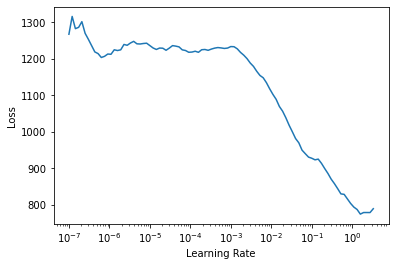

In [ ]:
learns.lr_find()

In [ ]:
learns.fit_one_cycle(200,lr_max = 1e-2)

epoch,train_loss,valid_loss,age_l1,CatA_accuracy,CatB_accuracy,time
0,172.304489,73.681015,6.389621,0.329350,0.241225,00:14
1,59.104317,46.241230,4.879272,0.358476,0.235997,00:13
2,37.762859,45.983932,4.861627,0.386109,0.233010,00:13
3,30.433044,37.375439,4.280643,0.346527,0.259149,00:13
4,29.802696,38.994625,4.487583,0.374160,0.263630,00:14
5,28.057837,54.413921,5.313333,0.374907,0.269604,00:14
6,26.264828,36.099991,4.149526,0.366692,0.253921,00:14
7,27.121931,49.609299,5.122088,0.386856,0.237491,00:14
8,28.329487,37.168968,4.242389,0.374160,0.269604,00:14
9,26.919765,36.691769,4.178817,0.343540,0.235250,00:14


In [ ]:
learns.validate()

(#4) [39.42795181274414,4.103663444519043,0.4645257592201233,0.23898431658744812]

The best learner was learn7 using MFEDSQRT10:<br/>
[0.9878523945808411, 4.711941242218018, 0.9678865075111389, 0.9051530957221985]